In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem.snowball import FrenchStemmer
from stop_words import get_stop_words
import string
from wordcloud import WordCloud
from spellchecker import SpellChecker
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc

In [76]:
plt.rcParams['text.color'] = 'black'
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = [6, 6]

In [46]:
# needed for tokenization
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# You need the averaged_perceptron_tagger resource to determine the context of a word in a sentence.

[nltk_data] Downloading package punkt to /Users/nohossat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nohossat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [47]:
df = pd.read_csv("booking_0206.csv", na_values=[''], decimal=',', encoding="utf8", escapechar='\\')

## Exploration des données

In [48]:
df.head()

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
0,Jean,France,1.0,2018-07-30,Exceptionnel,"Accueil, lit confortable, choix au petit déjeuner",None,10.0,Hôtel,Paris,8.0
1,Fabienne,France,0.0,2020-03-17,Très bien,Très bonne localisation \nPersonnel très agréable,Chambre très bruyante,8.0,Hôtel,Paris,8.0
2,Katarzyna,France,0.0,2020-03-15,Très agréable,Accueil très chaleureux et très pro. Très bien...,La chambre côté rue un peu de bruit. Le cadre ...,9.0,Hôtel,Paris,8.0
3,Guy,France,0.0,2020-03-13,bon séjour nous reviendrons,chambre très petite,calme pour Paris,7.0,Hôtel,Paris,8.0
4,Audrey,France,0.0,2020-03-12,Fabuleux,None,Services très bien et très bien situé,9.0,Hôtel,Paris,8.0


In [49]:
#dimensions du dataframe
print(f'Le dataset a {df.shape[0]} lignes et {df.shape[1]} colonnes.')
print('')
#affichage des variables
print(f'Les différents variables sont : ')

for col in df.columns.values:
    print(f'- {col}')

Le dataset a 52048 lignes et 11 colonnes.

Les différents variables sont : 
- nom
- pays
- favorite
- date
- titre
- bons_points
- mauvais_points
- note
- type_etablissement
- lieu
- note_etablissement


### Statistiques descriptives

In [50]:
#statistiques descriptives du dataset
df.describe(include='all')

,nom,pays,favorite,date,titre,bons_points,mauvais_points,note,type_etablissement,lieu,note_etablissement
count,50815,50817,52002,52046,50819,50905,51325,50808.000000,52046,52046,52046.000000
unique,9636,131,2,1222,14667,33270,28137,NaN,10,4,NaN
top,Anonyme,France,0.0,None,Bien,Ce client n'a pas laissé de commentaire.,None,NaN,Hôtel,Cannes,NaN
freq,2506,43991,51148,1230,7914,7470,18049,NaN,41466,14644,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.920617,NaN,NaN,7.889899
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.692679,NaN,NaN,0.804683
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,4.600000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.100000,NaN,NaN,7.500000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,8.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.200000,NaN,NaN,8.400000


>Les statistiques descriptives nous donnent pas d'élèments pertinents puisque la plupart de nos variables sont de type object

## Sélection des variables

Dans notre analyse, on partira sur deux hypothèses pour déterminer la polarité des commentaires:
    - calcul de la polarité des commentaires récoltés
    - utilisation de la colonne note pour déterminer la polarité
    
On conservera donc toutes les variables qui constituent le commentaire final et la note associée.

In [51]:
data = df.drop(['nom', 'pays', 'favorite', 'date', 'type_etablissement', 'lieu', 'note_etablissement'], axis= 1)

data.head()

,titre,bons_points,mauvais_points,note
0,Exceptionnel,"Accueil, lit confortable, choix au petit déjeuner",None,10.0
1,Très bien,Très bonne localisation \nPersonnel très agréable,Chambre très bruyante,8.0
2,Très agréable,Accueil très chaleureux et très pro. Très bien...,La chambre côté rue un peu de bruit. Le cadre ...,9.0
3,bon séjour nous reviendrons,chambre très petite,calme pour Paris,7.0
4,Fabuleux,None,Services très bien et très bien situé,9.0


## Traitement des valeurs manquantes

In [52]:
data.isna().sum()

titre             1229
bons_points       1143
mauvais_points     723
note              1240
dtype: int64

In [53]:
# we delete empty rows
data = data.dropna(how='all')

# we delete the rows where the note is null - have to be careful with this
data = data.loc[data.note.notna()]

# in the titre, bons_points and mauvais points columns we replace nan by empty strings
data = data.fillna('')

data.isna().sum()

titre             0
bons_points       0
mauvais_points    0
note              0
dtype: int64

## Concaténation des colonnes Titre, Bons Points et Mauvais Points

In [54]:
# merge columns
data['review'] = data.titre + ' ' + data.bons_points + ' ' + data.mauvais_points
data = data[['review', 'note']]
data

,review,note
0,"Exceptionnel Accueil, lit confortable, choix a...",10.0
1,Très bien Très bonne localisation \nPersonnel ...,8.0
2,Très agréable Accueil très chaleureux et très ...,9.0
3,bon séjour nous reviendrons chambre très petit...,7.0
4,Fabuleux None Services très bien et très bien...,9.0
...,...,...
52043,Exceptionnel Établissement bien placé et chamb...,10.0
52044,"Peu confortable ! La situation géographique, p...",4.6
52045,"Exceptionnel Bon emplacement, propreté des lie...",10.0
52046,Exceptionnel Appartement très fonctionnel avec...,10.0


On a remarqué que certains commentaires étaient des commentaires automatiques de Booking, on s'assure qu'il n'y en a plus après le retrait des lignes sans note

In [55]:
#suppression de deux phrases récurrentes dans les données
commentaires_booking = ["Ce commentaire n'apparaît pas car il ne respecte pas notre charte.", "Ce client n'a pas laissé de commentaire."]
mask = (data.review.isin(commentaires_booking))
data = data.loc[~mask]
data.shape

(50808, 2)

## Proportion de commentaires positifs / négatifs

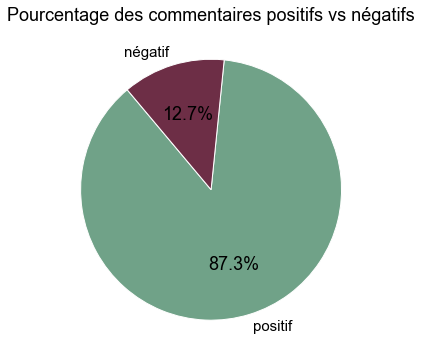

In [94]:
#diagramme circulaire des modalités de la polarité des commentaires
data_percentages = data.note.groupby(data.note > 6).size() / data.shape[0]

fig1, ax1 = plt.subplots()

plt.title("Pourcentage des commentaires positifs vs négatifs", fontsize=18)
labels = ['positif', 'négatif']
sizes = [data_percentages[1], data_percentages[0]]

patches, texts, autotexts = ax1.pie(sizes,  labels=labels, autopct='%1.1f%%', startangle=130, colors = ['#70A288', '#6D2E46'])
texts[0].set_fontsize(15)
texts[1].set_fontsize(15)

## Préparer notre jeu de données pour le NLP

Pour optimiser notre modélisation, on souhaite **conserver seulement les mots / caractères les plus pertinents pour déterminer la polarité d'un commentaire**. 

Il y a deux approches : 
- découpage par mot
- découpage par groupe de mots (bag of words)

### Tokenisation

Pour ce faire, on va passer par 4 étapes :

- correction orthographique - trop de preprocessing, il faut flagguer tous les noms propres, recuperer la liste des mots corrects en FR
- tokenisation
- retrait des stop words
- Lexicon Normalization : Stemming and Lemmatization

### 1 - Correction orthographique

In [56]:
# spell = SpellChecker('fr', 'fr_FR')
# spell = SpellChecker()

# find those words that may be misspelled
# misspelled = spell.unknown(['Nohossat', 'a', 'mangé', 'carote'])

# for word in misspelled:
    # Get the one `most likely` answer
    # print(spell.correction(word))

    # Get a list of `likely` options
    # print(spell.candidates(word))

### 1 - Tokenisation

Pour faciliter la compréhension du language naturel par la machine, on doit transformer nos chaînes de caractères en tokens.

>**tokens** : mots, ponctuation, symboles

La tokenisation basique consiste à séparer le texte par les espaces et la ponctuation. 

In [57]:
review_tokens = [word_tokenize(review) for review in data.review]

### 2 - retrait des stop words

In [58]:
def remove_stopwords(commentaire):
    # remove stop words from the review
    stop_words = get_stop_words('french')  
    
    # remove stop words, punctuation and words which length is below 2, numbers and none values
    commentaire = [word for word in commentaire if word.lower() not in stop_words and word not in string.punctuation and not word.isnumeric() and word.lower() != 'none' and len(word) > 2]
    
    return ' '.join(commentaire)

In [59]:
cleaned_review_tokens = [remove_stopwords(review) for review in review_tokens]
cleaned_review_tokens[:2]

['Exceptionnel Accueil lit confortable choix petit déjeuner',
 'bien bonne localisation Personnel agréable Chambre bruyante']

### 4 - Lexicon Normalization : Stemming & Lemmatization

La normalisation en NLP consiste à conserver la forme canonique des mots du corpus. On peut utiliser deux méthodes : le stemming et la lemmatization. 

#### Stemming

Pour éviter d'inclure les variations d'un mot dans notre corpus (ex: vouloir : veux, voulons, veuille, etc..), on va récuperer le radical du mot.

In [60]:
def stem_review(review):
    stem = FrenchStemmer()
    review = review.split(' ')
    return [stem.stem(word) for word in review]

In [61]:
normalized_tokens = [stem_review(review) for review in cleaned_review_tokens]

In [62]:
normalized_tokens[3]

['séjour', 'reviendron', 'chambr', 'petit', 'calm', 'paris']

#### Lemmatization

La lemmatization consiste à analyser le mot selon le contexte d'utilisation et le remplacer par une forme normalisée.

On détermine le contexte d'utilisation grâce à l'étiquetage morpho-syntaxique (Part-Of-Speech - POS Tagging ): on essaye d'attribuer une étiquette à chaque mot correspondant à sa fonctionnalité grammaticale dans la phrase (nom propre, adjectif, etc...)

In [63]:
cleaned_review_tokens[2]

'agréable Accueil chaleureux pro bien situé Proche Gare Montparnasse 10mn pied recommande chambre côté rue bruit cadre sympathique proche restaurants magasins'

In [64]:
def get_POS(review):
    review = review.split(' ')
    review = list(filter(None, review))
    return pos_tag(review)

In [65]:
# pos tag only work if all the element inside the list aren't empty
tokens_with_pos = [get_POS(review) for review in cleaned_review_tokens]

In [66]:
tokens_with_pos[3]

[('séjour', 'JJ'),
 ('reviendrons', 'NNS'),
 ('chambre', 'VBP'),
 ('petite', 'JJ'),
 ('calme', 'NN'),
 ('Paris', 'NNP')]

In [67]:
# how to lemmatize French TEXT ??? we are going to use spacy

In [68]:
# import spacy
# nlp = spacy.load('fr_core_news_md') # we have to load the this file first, we will see later

# doc = nlp(u"Exceptionnel Accueil lit confortable choix petit déjeuner")
# for token in doc:
    # print(token, token.lemma_)

>On obtient les tokens nettoyés et normalisés par commentaire.

## Frequency and Word Count

Pour observer la fréquence des mots, on va utiliser le corpus **cleaned_review_tokens** qui ne comprend pas la normalization et donc nous permet de voir les mots dans leur forme entière.

In [69]:
# we need to get all words
all_words = np.array(cleaned_review_tokens).flatten()
all_words = ' '.join(all_words).split() 

#calculer les 100 mots les plus fréquents
nb = 100
word_dist = nltk.FreqDist(all_words)

In [70]:
#affichage dans un dataframe des 7 mots les plus fréquents
word_frequency = pd.DataFrame(word_dist.most_common(nb), columns=['Word', 'Frequency'])
most_frequent = word_frequency.head(7)
most_frequent

,Word,Frequency
0,chambre,15003
1,bien,14867
2,petit,10000
3,Bien,9456
4,personnel,9061
5,déjeuner,8772
6,client,7776


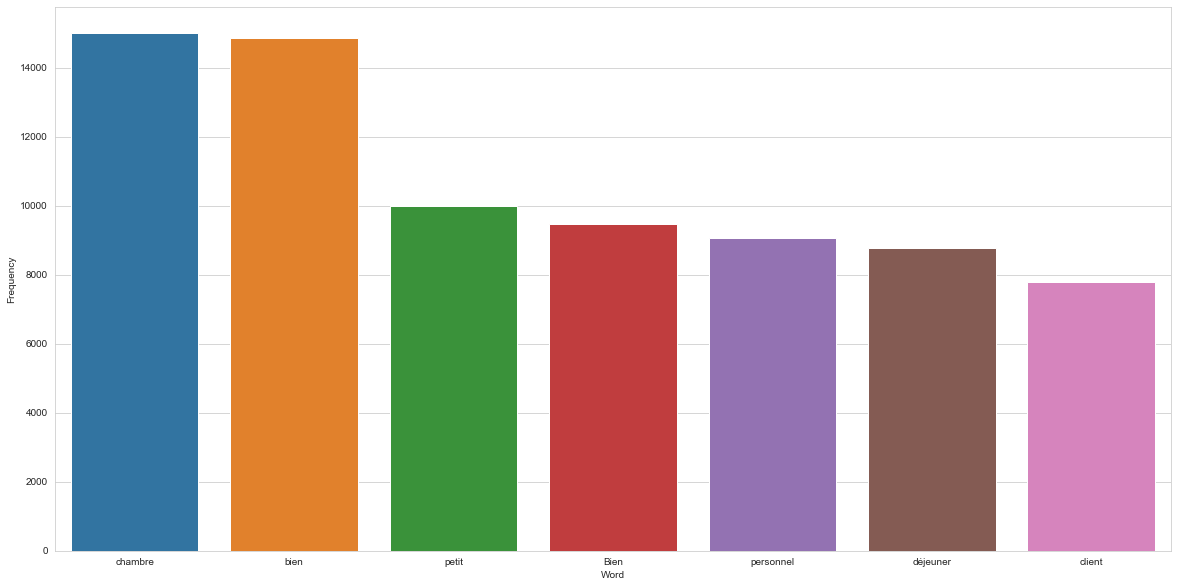

In [71]:
#histogramme des 7 mots les plus fréquents
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
sns.barplot(x="Word",y="Frequency", data=most_frequent)

In [72]:
#fonction pour générer un nuage de mots
def wcloud(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

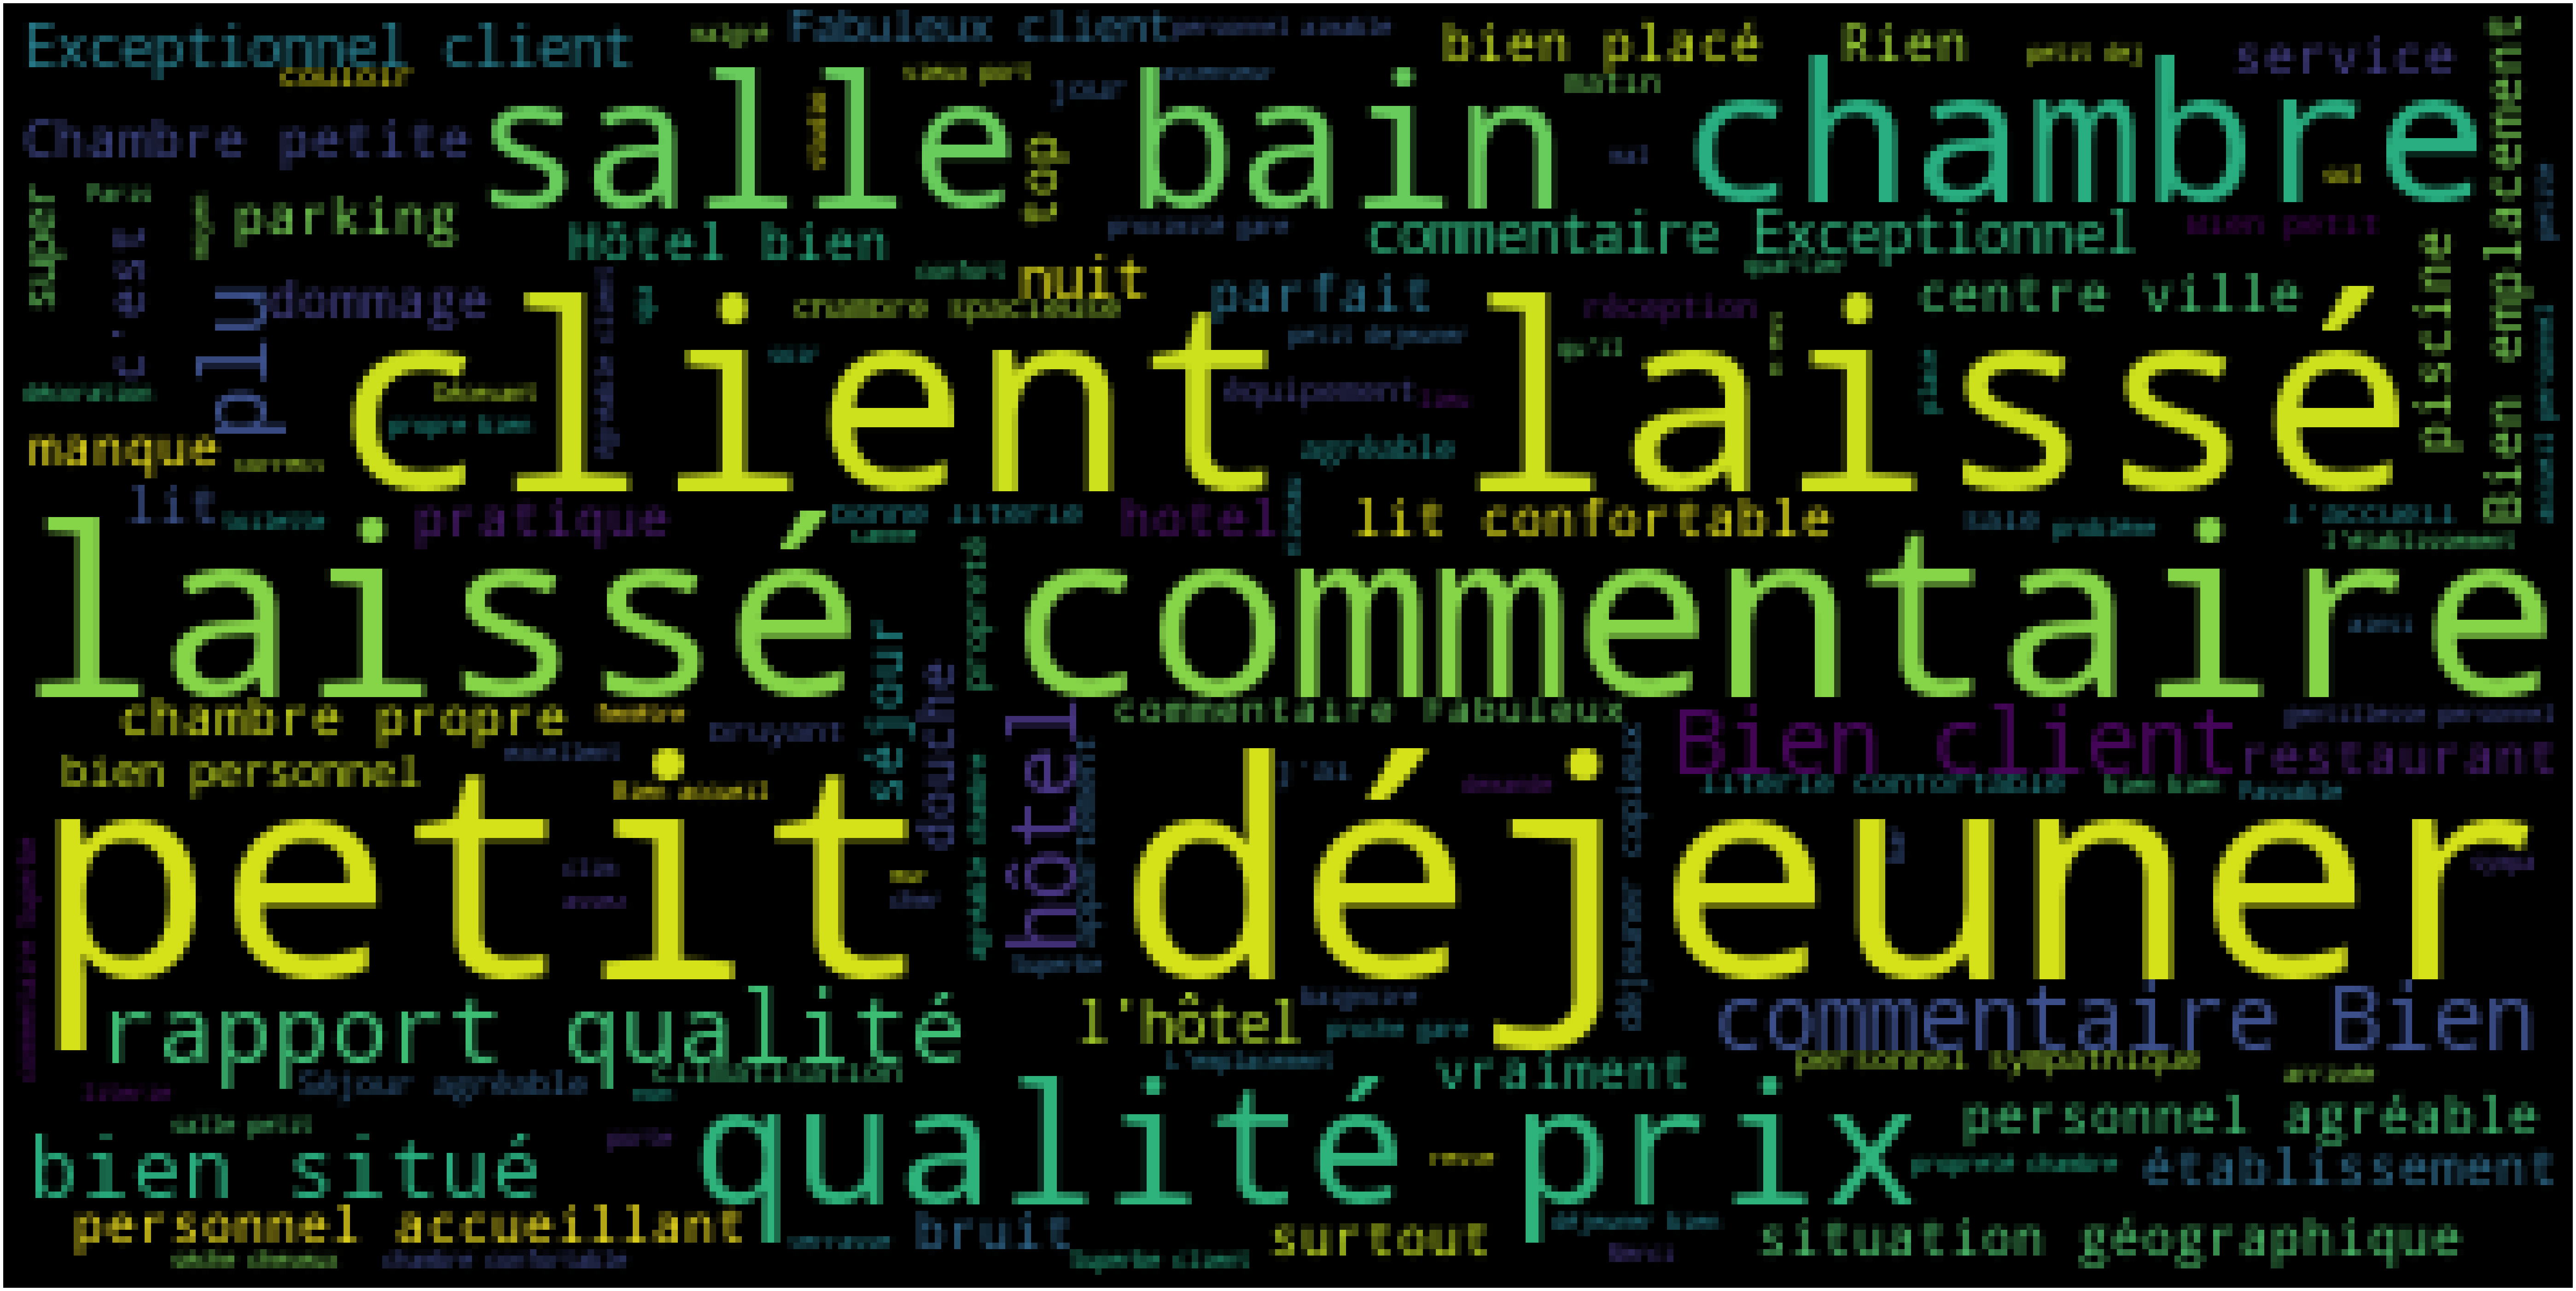

In [73]:
wcloud(all_words,'black','Common Words')

## Analyse de sentiments

Sentiment analysis is a process of identifying an attitude of the author on a topic that is being written about.

You will create a training data set to train a model. It is a supervised learning machine learning process, which requires you to associate each dataset with a “sentiment” for training. In this tutorial, your model will use the “positive” and “negative” sentiments.

### Première approche : Utilisation de la note Client

Avec les notes Booking, on va faire la répartition suivante : 

0 => 4 : négatif  
5 : neutre  
sup 5 : positif  

Mais je pense qu'il va falloir faire du binaire

#### Dataset 1

In [225]:
X = np.array([' '.join(review) for review in normalized_tokens])

In [234]:
notes_booking = data.note.copy()
notes_booking.loc[notes_booking < 5] = 0
notes_booking.loc[notes_booking >= 5] = 1
notes_booking.unique()

array([1., 0.])

### Deuxième approche : Calcul de la polarité

On va utiliser le Pattern Analyzer de textBlob pour déterminer la polarité d'un commentaire

Une polarité de : 
* \- 1 : commentaire négatif
* 0 : commentaire neutre
* 1 : commentaire positif

In [150]:
# sentiment renvoie un tuple avec la polarité et la subjectivite, on veut récuperer juste la première valeur
polarite = [TextBlob(' '.join(review), analyzer=PatternAnalyzer()).sentiment[0] for review in normalized_tokens]
# polarite[0]

0.2

#### Dataset 2

In [158]:
target_polarite = np.array(polarite).reshape(-1, 1)

(50808, 1)

>est-ce que la polarité calculée et les notes sont corrélées ?
si oui, on peut utiliser la note booking comme target par exemple

### Corrélation entre les notes Booking et la polarité calculée

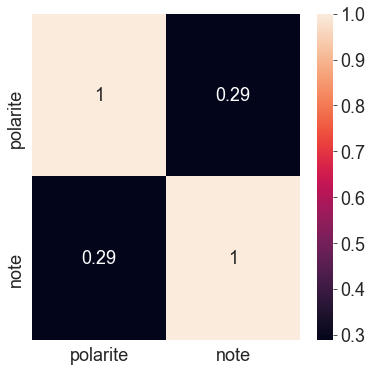

In [164]:
d = {'polarite': polarite, 'note': y.values}
polarites = pd.DataFrame(data=d)

df_corr = polarites.corr()
sns.heatmap(df_corr, annot=True)

>Soit il y a un problème de calcul dans la polarité soit les valeurs ne sont vraiment pas corrélées. 
Il va donc falloir tester les modèles sur les deux targets pour voir avec quelle target on a les meilleurs résultats

## Model

On va tester plusieurs modèles pour voir celui qui nous sort les meilleurs résultats : 
   - Random Forest
   - SVM
   - Naive Bayes

### Modélisation avec les notes Booking

In [235]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, notes_booking, test_size=0.2, random_state=0)

Avant d'entraîner le modèle on a deux opérations à réaliser :

CountVectorizer de Scikit-learn est utilisé pour transformer un corpus de mots en vecteurs/occurence des mots 


- obtenir l'occurence des mots dans chaque review (Count Vectorizer) - A BIEN EXPLIQUER
- TFIDTransformer : The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.


In [242]:
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train)
feat_train = pipe.transform(X_train).toarray()

In [263]:
def run_model(model, X_train, y_train, params=None, random_state=None):
    # measures the time taken by the model to run
    start_time = time.time()
    
    # run a grid search if params set
    if params :
        clf = GridSearchCV(model(), params, cv = 5)
    else :
        if random_state:
            clf = model(random_state=random_state)
        else:
            clf = model()
        best_params = None
    
    clf.fit(X_train, y_train)
    
    if params:
         best_params = clf.best_params_
            
    y_pred = clf.predict(X_train)
    
    # we will record some metrics in a CSV file for presentation
    accuracy = accuracy_score(y_train, y_pred)
    endtime = time.time() - start_time
    
    results = [[accuracy, best_params, endtime]]
    
    # save to csv
    cols = ['accuracy', 'best paramaters', 'duration']
    
    try:
        backup = pd.read_csv('booking_models_metrics.csv')
    except:
        backup = pd.DataFrame([], columns=cols)
    
    model_metrics = pd.DataFrame(results, columns=cols)
    
    backup = pd.concat([backup, model_metrics])
    backup.to_csv('booking_models_metrics.csv')
    
    return backup

In [258]:
run_model(BernoulliNB, feat_train, y_train)

,accuracy,best paramaters,duration
0,0.927668,None,26.340457


In [ ]:
run_model(MultinomialNB, feat_train, y_train, params={'alpha' : [0, 1, 5, 10]})

In [ ]:
run_model(LogisticRegression, feat_train, y_train, random_state=0)

In [ ]:
param_rf = { 'n_estimators' : [50, 100, 300]}

run_model(GradientBoostingClassifier, feat_train, y_train, params=param_rf, random_state=0)

In [ ]:
param_rf = { 'max_depth' : [40, 60],
             'n_estimators' : [50, 200]}

run_model(RandomForestClassifier, feat_train, y_train, params=param_rf, random_state=0)

In [ ]:
run_model(XGBClassifier, feat_train, y_train, param_svm, random_state=0)

In [ ]:
param_svm = { 'C': [10,100],
              'gamma': [1, 0.1, 0.0001],
              'kernel': ['rbf','sigmoid', 'poly']}

run_model(SVC, feat_train, y_train, param_svm, random_state=0)

In [ ]:
param_ada = { 'base_estimator' : [MultinomialNB, SVC],
              'n_estimators' : [50, 100, 200]}

run_model(AdaBoostClassifier, feat_train, y_train, param_ada, random_state=0)

## Feature importance

Voir si on peut l'obtenir pour les modèles ensemblistes

## Limits to the model

In this step you built and tested the model. You also explored some of its limitations, such as not detecting sarcasm in particular examples. Your completed code still has artifacts leftover from following the tutorial, so the next step will guide you through aligning the code to Python’s best practices.